# Plot the standardized validation residuals for all methods in July 2021

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from cartopy import crs as ccrs, feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmcrameri import cm


In [2]:
YEARMONTH = "202107"
BLOCKS = dict(
    b1=dict(
        name="Corn Belt",
        extents=[-95.5, -89.5, 39.5, 45.5],
        locators_lon=[-94, -92, -90],
        locators_lat=[40, 42, 44],
    ),
    b2=dict(
        name="Cropland",
        extents=[-104.5, -98.5, 36, 42],
        locators_lon=[-104, -102, -100],
        locators_lat=[37, 39, 41],
    ),
)


In [3]:
def prep_axes(ax, region, label_region=False):
    ax.set_extent(region["extents"], crs=ccrs.PlateCarree())
    ax.spines[:].set_color("gray")
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        linewidth=0.8,
        color="black",
        alpha=0.5,
        linestyle="--",
        draw_labels=True,
        zorder=0,
    )
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator(region["locators_lon"])
    gl.ylocator = mticker.FixedLocator(region["locators_lat"])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if label_region:
        ax.text(
            -0.2,
            0.5,
            region["name"],
            va="bottom",
            ha="center",
            rotation="vertical",
            rotation_mode="anchor",
            transform=ax.transAxes,
            fontsize=15,
        )


In [4]:
residuals = []
for block in BLOCKS.keys():
    df = pd.read_csv(
        f"../data/intermediate/validation/{YEARMONTH}/validation_results_{block}.csv",
        index_col=0,
    )
    residuals.append(df)

df_residuals = pd.concat(residuals, axis=0).reset_index(drop=True)
df_residuals.head()


,Method,Month,Region,lat,lon,data,predictions,rmspe,difference,ratio,INT,DSS
0,Trend surface,202107,b1,40.025,-94.725,2.288461,2.504674,0.591556,0.216213,0.365499,2.322574,-0.916409
1,Trend surface,202107,b1,40.025,-93.475,1.241077,2.612256,0.549991,1.371180,2.493094,13.818910,5.019810
2,Trend surface,202107,b1,40.025,-91.675,2.409288,2.567297,0.559071,0.158009,0.282628,2.195033,-1.083078
3,Trend surface,202107,b1,40.025,-91.625,2.269722,2.565487,0.567656,0.295765,0.521028,2.228740,-0.861008
4,Trend surface,202107,b1,40.025,-90.525,3.168826,2.523535,0.575585,-0.645291,-1.121104,2.259872,0.152140


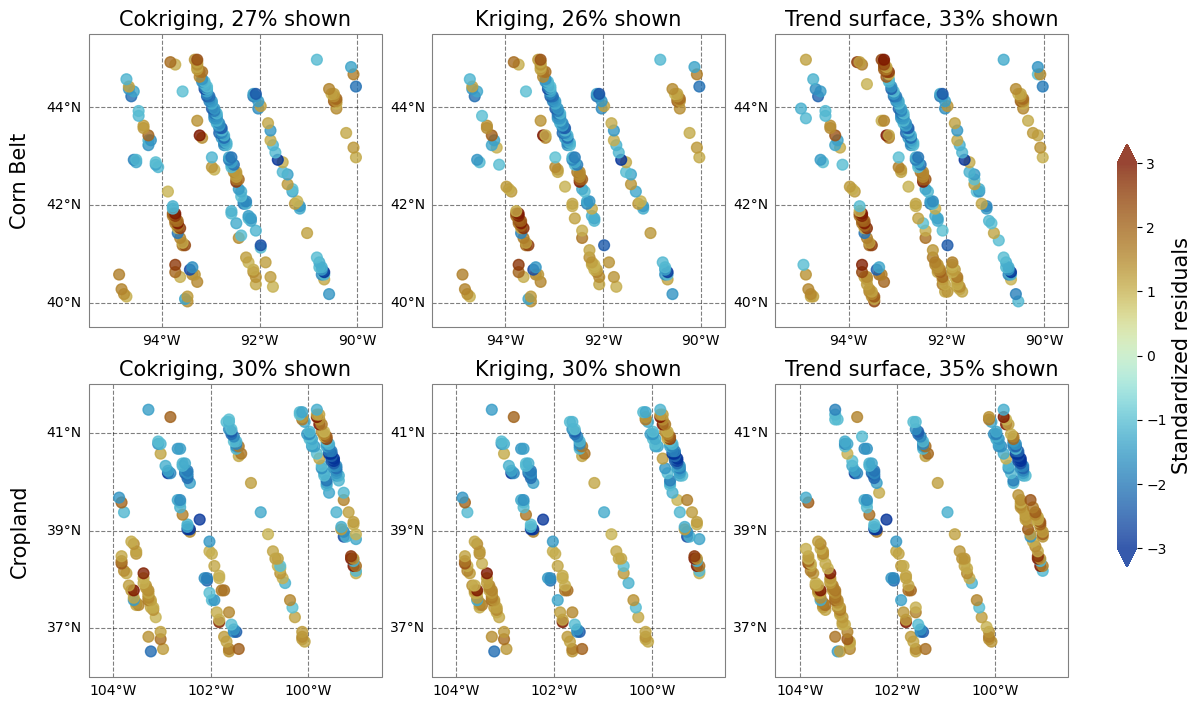

In [5]:
threshold = 1
methods = ["Cokriging", "Kriging", "Trend surface"]

fig, axes = plt.subplots(
    len(BLOCKS.keys()),
    len(methods),
    figsize=(12, 7),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True,
)
for i, block in enumerate(BLOCKS.items()):
    id, region = block
    for j, method in enumerate(methods):
        if j == 0:
            prep_axes(axes[i, j], region, label_region=True)
        else:
            prep_axes(axes[i, j], region, label_region=False)

        conditions = (df_residuals["Method"] == method) & (df_residuals["Region"] == id)
        df_method = df_residuals.loc[conditions, :]
        count_method = df_method.groupby("Method")["difference"].count().values[0]
        df_threshhold = df_method.loc[
            ((df_method["ratio"] > threshold) | (df_method["ratio"] < -threshold)), :
        ]
        count_threshold = df_threshhold.groupby("Method")["difference"].count().values[0]
        frac = int((count_threshold / count_method) * 100)
        field = axes[i, j].scatter(
            x=df_threshhold["lon"],
            y=df_threshhold["lat"],
            c=df_threshhold["ratio"],
            s=60,
            alpha=0.8,
            transform=ccrs.PlateCarree(),
            cmap=cm.roma_r,
            vmin=-3,
            vmax=3,
        )
        axes[i, j].set_aspect(aspect="equal")
        axes[i, j].set_title(f"{method}, {frac}% shown", fontsize=15)

cb = fig.colorbar(field, extend="both", shrink=0.65, ax=axes)
cb.set_label(label="Standardized residuals", fontsize=15)
cb.outline.set_visible(False)


In [6]:
fig.savefig(
    f"../figures/validation_residuals_extremes_{YEARMONTH}.pdf",
    dpi=300,
    bbox_inches="tight",
)
